In [18]:
from transformers import RobertaModel, RobertaTokenizer, DataCollatorWithPadding
from transformers import get_scheduler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [4]:
# checkpoint = '/root/autodl-tmp/cache'
class RobertaBilstmClassifier(nn.Module):
    def __init__(self,checkpoint='roberta-base', num_classes=3, hidden_size=32):
        super(RobertaBilstmClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(checkpoint)
        
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(input_size=self.roberta.config.hidden_size, 
                            hidden_size=hidden_size, 
                            bidirectional=True, 
                            batch_first=True,
                            dropout=0.2,
                            )
        self.fc1 = nn.Linear(hidden_size * 2, 32) # Multiply by 2 for bidirectional LSTM
        self.activation = nn.SiLU()  #Swish activation
        self.fc2 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        sequence_output = roberta_output.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)

        # sequence_output = self.dropout(sequence_output) # first dropout

        lstm_output, _ = self.lstm(sequence_output)
        lstm_output = lstm_output[:, -1, :]

        # lstm_output = self.dropout(lstm_output)# second dropout

        fc1_output = self.fc1(lstm_output)

        fc1_output = self.activation(fc1_output)

        # fc1_output = self.dropout(fc1_output) # third dropout

        fc2_output = self.fc2(fc1_output)

        output = self.softmax(fc2_output)
        return output


In [5]:
# Load dataset
data_files = {"train": "/Users/jianhongxu/python_project/twitter_dataset/data/train_dataset_85k.csv",
               "test": "/Users/jianhongxu/python_project/twitter_dataset/data/test_dataset_85k.csv"}
raw_datasets = load_dataset("csv",data_files=data_files)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tweet', 'class'],
        num_rows: 68306
    })
    test: Dataset({
        features: ['tweet', 'class'],
        num_rows: 17077
    })
})

In [6]:
unique_labels = list(set(raw_datasets['train']['class']))
unique_labels

['ADHD', 'BIPOLAR', 'DEPRESSION']

In [7]:
from datasets import ClassLabel
raw_datasets = raw_datasets.rename_column("class","labels")
raw_datasets = raw_datasets.cast_column('labels',ClassLabel(names=unique_labels))
raw_datasets['train'][0]

{'tweet': 'marked as toread have you seen me by kate white httpurl',
 'labels': 0}

In [10]:
# checkpoint = '/root/autodl-tmp/cache'
checkpoint = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['tweet'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 68306
    })
    test: Dataset({
        features: ['tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 17077
    })
})

In [11]:
print(tokenized_datasets['train'][0]['tweet'])
input_ids = tokenized_datasets['train'][0]['input_ids']
print(input_ids)
print(tokenized_datasets['train'][0]['attention_mask'])
decode_token = tokenizer.convert_ids_to_tokens(input_ids)
print(decode_token)

marked as toread have you seen me by kate white httpurl
[0, 18584, 25, 7, 12745, 33, 47, 450, 162, 30, 449, 877, 1104, 2054, 6423, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['<s>', 'marked', 'Ġas', 'Ġto', 'read', 'Ġhave', 'Ġyou', 'Ġseen', 'Ġme', 'Ġby', 'Ġk', 'ate', 'Ġwhite', 'Ġhttp', 'url', '</s>']


In [12]:
tokenized_datasets = tokenized_datasets.remove_columns(['tweet'])
tokenized_datasets.set_format('torch')
tokenized_datasets['train'].column_names

['labels', 'input_ids', 'attention_mask']

In [13]:

test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=8, collate_fn=data_collator
)

In [14]:
# Set up model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaBilstmClassifier(num_classes=3, checkpoint=checkpoint, hidden_size=32)
model = model.to(device)
device
# # Print model summary
# def count_parameters(model):
#         return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
# print("Model Architecture:")
# print(model)
# print(f"\nTrainable parameters: {count_parameters(model):,}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


device(type='cpu')

In [17]:

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5,weight_decay=0.01)
print(optimizer)




AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.01
)


In [ ]:
from sklearn.model_selection import KFold
bs =16
K=5
num_epochs = 2
  
criterion = nn.CrossEntropyLoss()
kf = KFold(n_splits=K, shuffle=True, random_state=42)


fold_train_losses = []
fold_train_accuracies = []
fold_val_losses = []
fold_val_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(range(len(tokenized_datasets['train'])))):
    print(f"\nFold {fold + 1}/{K}")
    train_dataset = tokenized_datasets['train'].select(train_index)
    val_dataset = tokenized_datasets['train'].select(val_index)

    train_dataloader = DataLoader(
        train_dataset,shuffle=True, batch_size=bs, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        val_dataset, batch_size=bs, collate_fn=data_collator
    )
    
    num_training_steps = num_epochs * len(train_dataloader)

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    ) 
    # print(f"number training  steps:{num_training_steps}")

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        progress_bar = tqdm(range(len(train_dataloader)), desc=f"[epoch{epoch+1}/epochs{num_epochs}]")
        model.train()
        train_total_loss = 0
        train_correct = 0
        train_total = 0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(outputs, batch['labels'])

            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
     

            train_total_loss +=loss.item()

            _, preds = outputs.max(1)
            train_correct += torch.sum(preds == batch["labels"]).cpu()

            train_total +=batch["labels"].size(0)
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}', 'train_accuracy': f'{train_correct/train_total:.4f}'})
            progress_bar.update(1)
    
        train_avg_loss = train_total_loss / len(train_dataloader)
        train_avg_accuracy = train_correct / train_total
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_avg_accuracy)


        model.eval()
        eval_total_loss = 0
        eval_correct_predictions = 0
        eval_total = 0

        with torch.no_grad():
            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(batch['input_ids'], batch['attention_mask'])
                loss = criterion(outputs,batch['labels'])

                eval_total_loss += loss.item()
                _, preds = outputs.max(1)
                eval_correct_predictions += torch.sum(preds == batch["labels"]).cpu()
                eval_total +=batch["labels"].size(0)

        eval_avg_loss = eval_total_loss / len(eval_dataloader)
        eval_avg_accuracy = eval_correct_predictions / eval_total
        val_losses.append(eval_avg_loss)
        val_accuracies.append(eval_avg_accuracy)
        progress_bar.set_postfix({'train_loss': f'{train_avg_loss:.4f}', 'training_accuracy': f'{train_avg_accuracy:.4f}',
                              'Val_loss': f'{eval_avg_loss:.4f}', 'Val_accuracy': f'{eval_avg_accuracy:.4f}'})
    fold_train_losses.append(train_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_losses.append(val_losses)
    fold_val_accuracies.append(val_accuracies)
avg_val_accuracy = np.mean([val_accuracies[-1] for val_accuracies in fold_val_accuracies])
print(f"\nAverage Validation Accuracy across 5 folds: {avg_val_accuracy:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to NumPy arrays
fold_train_losses = np.array(fold_train_losses)
fold_train_accuracies = np.array(fold_train_accuracies)
fold_val_losses = np.array(fold_val_losses)
fold_val_accuracies = np.array(fold_val_accuracies)

# Compute means and standard deviations
mean_train_losses = np.mean(fold_train_losses, axis=0)
std_train_losses = np.std(fold_train_losses, axis=0)
mean_train_accuracies = np.mean(fold_train_accuracies, axis=0)
std_train_accuracies = np.std(fold_train_accuracies, axis=0)
mean_val_losses = np.mean(fold_val_losses, axis=0)
std_val_losses = np.std(fold_val_losses, axis=0)
mean_val_accuracies = np.mean(fold_val_accuracies, axis=0)
std_val_accuracies = np.std(fold_val_accuracies, axis=0)

# Plotting
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_train_losses, label='Train Loss', color='blue')
plt.fill_between(epochs, mean_train_losses - std_train_losses, mean_train_losses + std_train_losses, color='blue', alpha=0.2)
plt.plot(epochs, mean_val_losses, label='Validation Loss', color='orange')
plt.fill_between(epochs, mean_val_losses - std_val_losses, mean_val_losses + std_val_losses, color='orange', alpha=0.2)
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_train_accuracies, label='Train Accuracy', color='blue')
plt.fill_between(epochs, mean_train_accuracies - std_train_accuracies, mean_train_accuracies + std_train_accuracies, color='blue', alpha=0.2)
plt.plot(epochs, mean_val_accuracies, label='Validation Accuracy', color='orange')
plt.fill_between(epochs, mean_val_accuracies - std_val_accuracies, mean_val_accuracies + std_val_accuracies, color='orange', alpha=0.2)
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_train_losses, label='Train Loss', color='blue', marker='o')
plt.fill_between(epochs, mean_train_losses - std_train_losses, mean_train_losses + std_train_losses, color='blue', alpha=0.1)
plt.plot(epochs, mean_val_losses, label='Validation Loss', color='orange', marker='s')
plt.fill_between(epochs, mean_val_losses - std_val_losses, mean_val_losses + std_val_losses, color='orange', alpha=0.1)
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.fill_between(epochs, mean_train_accuracies - std_train_accuracies, mean_train_accuracies + std_train_accuracies, color='blue', alpha=0.1)
plt.plot(epochs, mean_val_accuracies, label='Validation Accuracy', color='orange', marker='s')
plt.fill_between(epochs, mean_val_accuracies - std_val_accuracies, mean_val_accuracies + std_val_accuracies, color='orange', alpha=0.1)
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Loss Plot with Individual Folds
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(epochs, fold_train_losses[i], color='lightblue', linestyle='--', alpha=0.5)
    plt.plot(epochs, fold_val_losses[i], color='lightcoral', linestyle='--', alpha=0.5)
plt.plot(epochs, mean_train_losses, label='Average Train Loss', color='blue', linewidth=2)
plt.plot(epochs, mean_val_losses, label='Average Val Loss', color='red', linewidth=2)
plt.title('Loss per Epoch with Individual Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot with Individual Folds
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(epochs, fold_train_accuracies[i], color='lightblue', linestyle='--', alpha=0.5)
    plt.plot(epochs, fold_val_accuracies[i], color='lightcoral', linestyle='--', alpha=0.5)
plt.plot(epochs, mean_train_accuracies, label='Average Train Accuracy', color='blue', linewidth=2)
plt.plot(epochs, mean_val_accuracies, label='Average Val Accuracy', color='red', linewidth=2)
plt.title('Accuracy per Epoch with Individual Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


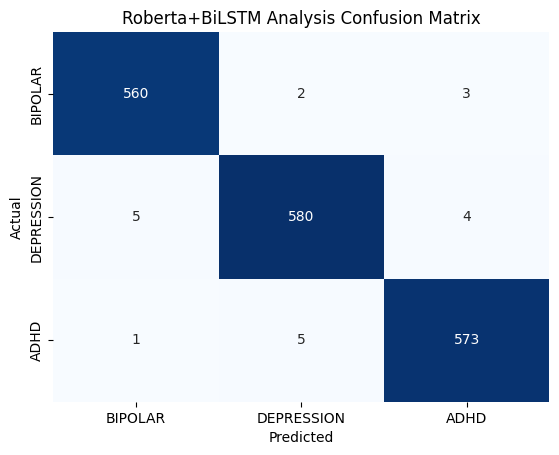

              precision    recall  f1-score   support

     BIPOLAR       0.99      0.99      0.99       565
  DEPRESSION       0.99      0.98      0.99       589
        ADHD       0.99      0.99      0.99       579

    accuracy                           0.99      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       0.99      0.99      0.99      1733



In [ ]:
# Evaluation
# metric = evaluate.load("accuracy")
model.eval()

all_predictions = []
all_labels = []

for batch in test_dataloader:
    batch = {k: v.to(device) for k,v in batch.items()}
    with torch.no_grad():
        outputs = model(batch['input_ids'],batch['attention_mask'])
    
    _, predictions = outputs.max(1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

    # metric.add_batch(predictions=predictions, References=batch["labels"])

# results = metric.compute()
# print("Evaluation Results:", results)

conf_matrix = confusion_matrix(all_labels, all_predictions)
# labels=["ADHD", "BIPO", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta+BiLSTM Analysis Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_predictions, target_names=unique_labels))